In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis, geom, rv_histogram, powerlaw, expon
from datetime import timedelta

In [34]:
figsize = (4,3)

# Trades data analysis

I am performing walk forward testing of a trading algorithm that I wrote. <br>
The goal of this analysis is to draw some meaningfull conclusions about the performance of this account.

<i> For the time being I decided not to share the dataset. </i>

This is still a work in progress.

## The data

The data contains information on 92 trades performed by my trading algorithm.

In [35]:
path = "/home/dev/Desktop/OrdersReport.csv"

In [36]:
raw = pd.read_csv(path, index_col=None, header=0, sep=",")

In [37]:
df = raw.copy()

The available columns are listed below:

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticket          92 non-null     int64  
 1   Magic           92 non-null     int64  
 2   Comment         92 non-null     object 
 3   Open Datetime   92 non-null     object 
 4   Open Price      92 non-null     float64
 5   Close Datetime  92 non-null     object 
 6   Close Price     92 non-null     float64
 7   Type            92 non-null     int64  
 8   Lots            92 non-null     float64
 9   Symbol          92 non-null     object 
 10  Take Profit     92 non-null     float64
 11  Stop Loss       92 non-null     float64
 12  Profit          92 non-null     float64
 13  Swap            92 non-null     float64
 14  Commission      92 non-null     int64  
dtypes: float64(7), int64(4), object(4)
memory usage: 10.9+ KB


The names of columns are fairly self explanatory. <br>
However I feel I should provide more information on these:
* 'Ticket' is generated by the broker and is of no meaning. <br>
* 'Magic' column is used to distinguish between trading algorithms. <br>
* 'Comment' will be used to determine the reason why a trade was closed. <br>

## Data preparation

### Data checks

The data is generated by a script written in MQL4. <br>
During the setup of the trading algorithms I made a mistake and entered the wrong 'magic' number into the algorithm. <br>
To rectify this mistake I switch the magic number to the correct value.

In [39]:
df.loc[df['Magic'] == 12345, 'Magic'] = 4444

I expect that there are no missing values.

In [40]:
df.isna().sum()

Ticket            0
Magic             0
Comment           0
Open Datetime     0
Open Price        0
Close Datetime    0
Close Price       0
Type              0
Lots              0
Symbol            0
Take Profit       0
Stop Loss         0
Profit            0
Swap              0
Commission        0
dtype: int64

I then check for constant columns. I excpect the 'Commission' column to be all zeroes.

In [41]:
df.var() == 0

Ticket         False
Magic          False
Open Price     False
Close Price    False
Type           False
Lots           False
Take Profit    False
Stop Loss      False
Profit         False
Swap           False
Commission      True
dtype: bool

Indeed, the commision columns is all zeroes.

In [42]:
df['Commission'][0]

0

I expect that all open prices are positive, so I count how many are negative.

In [43]:
df[df['Open Price'] <= 0]['Open Price'].count()

0

The same should apply to close prices.

In [44]:
df[df['Close Price'] <= 0]['Close Price'].count()

0

Lots also should be positive.

In [45]:
df[df['Lots'] <= 0]['Lots'].count()

0

### Transformations

For aesthetic reasons, I strip the names of symbols from "+" and ".".

In [46]:
df['Symbol'] = df['Symbol'].apply(lambda x: x.replace("+", ""))
df['Symbol'] = df['Symbol'].apply(lambda x: x.replace(".", ""))

Convert columns with timestamps from strings to datetimes.

In [47]:
df['Open Datetime'] = pd.to_datetime(df['Open Datetime'])
df['Close Datetime'] = pd.to_datetime(df['Close Datetime'])

Chronological order is of utmost importance since I shall be performing running calculations later.

In [48]:
df = df.sort_values('Open Datetime')
df = df.reset_index(drop=True)

### New columns

In this section I add new columns to the dataset.<br>
I shall definitely want to perform aggregations by time so I add the necessary columns. <br> 
I start with extracting the date, hour and day of week from the "Open Datetime" column.

In [49]:
df['Open Date'] = df['Open Datetime'].dt.date
df['Open Hour'] = df['Open Datetime'].dt.hour    
df['Open Day'] = df['Open Datetime'].dt.day_name()
df['Open Datetime Seconds'] = pd.to_datetime(df['Open Datetime'], origin='unix').astype('int') 

I extract the same information as above for the "Close Datetime" column.

In [50]:
df['Close Date'] = df['Close Datetime'].dt.date
df['Close Hour'] = df['Close Datetime'].dt.hour    
df['Close Day'] = df['Close Datetime'].dt.day_name()
df['Close Datetime Seconds'] = pd.to_datetime(df['Close Datetime'], origin='unix').astype('int')

I calculate the duration of individual trades. The final value is in minutes.

In [51]:
df['Duration'] = (df['Close Datetime'] - df['Open Datetime'])
df['Duration'] = df['Duration'].apply(lambda x: x.total_seconds() / 60)

I create a new column that is equall to the net profit from a trade.

In [52]:
df['Profit'] = df['Profit'] + df['Swap'] + df['Commission']

I need a 'Profit Per Lot' column because different trades have different lot sizes.

In [53]:
df['Profit Per Lot'] = df['Profit'] / ( df['Lots'] / 0.01)

I add two columns to describe the direction of a trade.

In [54]:
df['Order Type'] = df['Type'].apply(lambda x: "Buy" if x == 0 else "Sell")
df['Direction'] = df['Type'].apply(lambda x: 1 if x == 0 else -1)

I extract the reason why a trade was closed from the 'Comment' column. The reason for closure is added by my broker to the end of my comment:

In [55]:
df['Comment'][0]

'srl-1.03-242[[sl]]'

In order to extract the reason for closure I search for specific strings in the comment.

In [56]:
df['Stop Loss Hit'] = df['Comment'].apply(lambda x: 1 if "[[sl]]" in x else 0)
df['Take Profit Hit'] = df['Comment'].apply(lambda x: 1 if "[[tp]]" in x else 0)

I calculate the percentage difference between the take profit and the stop loss columns. I define a helper function first:

In [57]:
def stops_dist(x):
    
    if x[2] == 1:                
        return (x[0] / x[1] - 1) * 100    
    else:    
        return (x[1] / x[0] - 1) * 100

It is then applied to a subset of the original data.

In [58]:
df['Stops Distance'] = df[['Take Profit', 'Stop Loss', 'Direction']].apply(stops_dist, axis=1)

### Useless columns

I delete unwanted columns:
* Ticket - Generated by the broker for their internal purposes.
* Commission - Constant column equall to zero.
* Comment - Information was extracted.
* Type - Information was extracted.
* Take Profit - Information was extracted and is not relevant to this analysis.
* Stop Loss - Information was extracted and is not relevant to this analysis.

In [59]:
unwanted = ['Ticket', 
            'Commission',             
            'Comment', 
            'Type', 
            'Take Profit', 
            'Stop Loss']

df.drop(unwanted, axis=1, inplace=True)

The shape of the original data was:

In [60]:
raw.shape

(92, 15)

After cleaning the shape is:

In [61]:
df.shape

(92, 24)

The clean data looks like this:

In [62]:
df.head()

,Magic,Open Datetime,Open Price,Close Datetime,Close Price,Lots,Symbol,Profit,Swap,Open Date,...,Close Hour,Close Day,Close Datetime Seconds,Duration,Profit Per Lot,Order Type,Direction,Stop Loss Hit,Take Profit Hit,Stops Distance
0,4444,2020-05-19 11:31:00,1.09543,2020-05-19 11:39:00,1.09538,0.01,EURUSD,0.21,0.0,2020-05-19,...,11,Tuesday,1589888340000000000,8.0,0.21,Sell,-1,1,0,0.457634
1,4444,2020-05-19 12:17:00,1.09548,2020-05-19 12:23:00,1.09539,0.01,EURUSD,0.38,0.0,2020-05-19,...,12,Tuesday,1589890980000000000,6.0,0.38,Sell,-1,1,0,0.452107
2,4444,2020-05-19 17:40:00,1.09250,2020-05-19 21:59:00,1.09257,0.01,EURUSD,0.30,0.0,2020-05-19,...,21,Tuesday,1589925540000000000,259.0,0.30,Buy,1,1,0,0.908866
3,4444,2020-05-20 13:03:00,1.09569,2020-05-20 13:20:00,1.09557,0.01,EURUSD,0.50,0.0,2020-05-20,...,13,Wednesday,1589980800000000000,17.0,0.50,Sell,-1,1,0,0.452949
4,4444,2020-05-20 13:57:00,1.09630,2020-05-20 14:29:00,1.09628,0.01,EURUSD,0.09,0.0,2020-05-20,...,14,Wednesday,1589984940000000000,32.0,0.09,Sell,-1,1,0,0.457257


## The basics

I'm going to start the analysis by computing basic statistics the should interest any algorithmic trader.

Trading started on:

In [63]:
start = df['Open Date'].min()
str(start)

'2020-05-19'

The last trade in the data was closed on:

In [64]:
stop = df['Close Date'].max()
str(stop)

'2020-06-16'

That means the algorithms traded for nearly a month.

In [65]:
str(stop - start)

'28 days, 0:00:00'

Trades over the period in question:

In [66]:
df.shape[0]

92

### Profit

#### Total profit

Over the period in question the algorithms achieved a profit of:

In [67]:
np.round(df['Profit'].sum(), 2)

118.02

#### Total profit by market

As can be seen the bulk of the profit comes from 'USDCHF'.

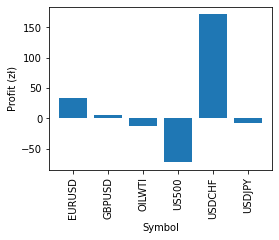

In [68]:
df_symbol = df[['Symbol', 'Profit']].groupby(['Symbol'], as_index=False).sum()

plt.figure(figsize=figsize)
plt.bar(df_symbol['Symbol'], df_symbol['Profit'])
plt.xticks(df_symbol['Symbol'], rotation=90)
plt.ylabel('Profit (zł)')
plt.xlabel('Symbol')
plt.show()

#### Total profit by market and trade direction
The most money was made by shorting 'USDCHF'. The most money was lost buying 'US500'.

In [69]:
df_mkt = df[['Symbol', 'Order Type', 'Direction', 'Profit']]
df_mkt = df_mkt.groupby(['Symbol', 'Order Type'], as_index=False)
df_mkt = df_mkt.agg({"Direction": [np.sum], "Profit": [np.sum]})
df_mkt.columns = df_mkt.columns.droplevel(1)
df_mkt['Direction'] = np.abs(df_mkt['Direction'])
df_mkt = df_mkt.rename(columns={"Direction" : "Number of trades"})
df_mkt.sort_values('Profit', ascending=False)

,Symbol,Order Type,Number of trades,Profit
8,USDCHF,Sell,10,180.18
0,EURUSD,Buy,12,82.49
2,GBPUSD,Buy,14,39.59
6,US500,Sell,5,3.86
9,USDJPY,Buy,1,-7.89
7,USDCHF,Buy,1,-8.20
4,OILWTI,Sell,4,-12.07
3,GBPUSD,Sell,21,-33.66
1,EURUSD,Sell,20,-49.54
5,US500,Buy,4,-76.74


#### Best days
The 3 best days were:

In [70]:
df_cdate = df[['Close Date', 'Profit']].groupby(['Close Date'], as_index=False).sum()
df_cdate.sort_values('Profit', ascending=False).head(3)

,Close Date,Profit
18,2020-06-15,139.11
16,2020-06-11,115.00
12,2020-06-05,94.04


#### Worst days
The worst 3 days were:

In [71]:
df_cdate.sort_values('Profit', ascending=True).head(3)

,Close Date,Profit
17,2020-06-12,-87.14
13,2020-06-08,-64.77
4,2020-05-26,-32.51


#### Costs

Amount of swap paid:

In [72]:
np.sum(df['Swap'])

-7.6

### Profit Per Lot
Since the trades vary in lot size it makes more sense to look at 'Profit Per Lot' than at 'Profit'.

#### Profit Per Lot histogram
As can be seen the distribution of 'Profit Per Lot' is nothing like a normal distribution:

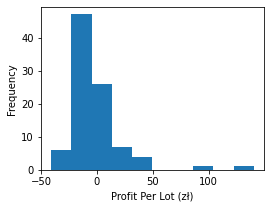

In [73]:
plt.figure(figsize=figsize)
plt.hist(df['Profit Per Lot'])
plt.ylabel('Frequency')
plt.xlabel('Profit Per Lot (zł)')
plt.show()

The mean of the distribution is:

In [74]:
np.round(np.mean(df['Profit Per Lot']), 2)

0.49

However the median is negative so the most frequent trades were small losses:

In [75]:
np.round(np.quantile(df['Profit Per Lot'], 0.5), 2)

-7.5

Standard deviation is:

In [76]:
np.round(np.std(df['Profit Per Lot']), 2)

22.85

Interquartile range:

In [77]:
np.round(np.quantile(df['Profit Per Lot'], 0.75) - np.quantile(df['Profit Per Lot'], 0.25))

14.0

The distribution exhibits positive skew of:

In [78]:
np.round(skew(df['Profit Per Lot']), 2)

3.06

The distribution is also leptokurtic: 

In [79]:
np.round(kurtosis(df['Profit Per Lot']), 2)

15.45

##### Comment
This is to be expected given the design of the algorithms. They have a predifined maximum loss per trade (they will take small losses more frequently) but can hold winning trades for up to a week (hence the big wins).

#### Profit Per Lot by symbol
Given the presence of outliers I think it is apropriate that for the rest of this section I analyze the median of 'Profit Per Lot'.<br>
As can be seen by far the worst market was 'US500'.

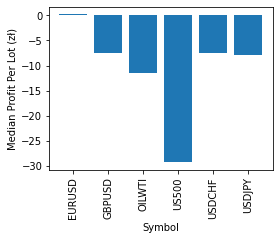

In [80]:
df_ppl = df[['Symbol', 'Profit Per Lot']].groupby(['Symbol'], as_index=False).quantile(0.5)
df_ppl['Symbol'] = df_ppl['Symbol'].astype('str')

plt.figure(figsize=figsize)
plt.bar(df_ppl['Symbol'], df_ppl['Profit Per Lot'])
plt.xticks(df_ppl['Symbol'], rotation=90)
plt.ylabel('Median Profit Per Lot (zł)')
plt.xlabel('Symbol')
plt.show()

#### Profit Per Lot by day of week
As can be seen no particular day of the week is better for trading.

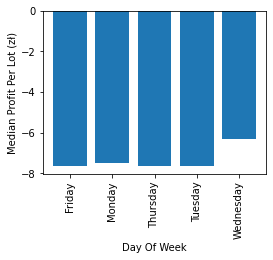

In [81]:
df_day = df[['Open Day', 'Profit Per Lot']].groupby(['Open Day'], as_index=False).quantile(0.5)
df_day.rename(columns={"Open Day": "Day Of Week"}, inplace=True)

plt.figure(figsize=figsize)
plt.bar(df_day['Day Of Week'], df_day['Profit Per Lot'])
plt.xticks(df_day['Day Of Week'], rotation=90)
plt.ylabel('Median Profit Per Lot (zł)')
plt.xlabel('Day Of Week')
plt.show()

#### Profit Per Lot by open hour
The median profit per lot is positive for 2pm and 4pm. 
This is very interesting because:
* Around 2pm typically macroeconomic news is released.
* The european session closes at 5pm.

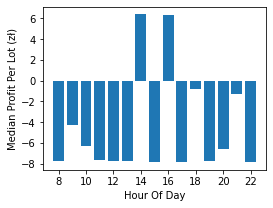

In [82]:
df_hour = df[['Open Hour', 'Profit Per Lot']].groupby(['Open Hour'], as_index=False).quantile(0.5)
df_hour.rename(columns={"Open Hour": "Hour Of Day"}, inplace=True)

plt.figure(figsize=figsize)
plt.bar(df_hour['Hour Of Day'], df_hour['Profit Per Lot'])
plt.ylabel('Median Profit Per Lot (zł)')
plt.xlabel('Hour Of Day')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))        

plt.show()

### Trades

#### Best trades

Here is a table with the 3 best trades.

In [83]:
df[['Symbol', 'Profit Per Lot', 'Profit']].sort_values('Profit Per Lot', ascending=False).head(3)

,Symbol,Profit Per Lot,Profit
79,US500,140.300,140.30
49,USDCHF,87.545,175.09
44,EURUSD,46.620,46.62


#### Worst trades

Here is a table with the 3 worst trades.

In [84]:
df[['Symbol', 'Profit Per Lot', 'Profit']].sort_values('Profit Per Lot', ascending=True).head(3)

,Symbol,Profit Per Lot,Profit
68,US500,-41.10,-41.10
74,US500,-39.29,-39.29
77,US500,-38.87,-38.87


#### Average win

A profitable trade on average nets:

In [85]:
avg_profit = np.round(df[df['Profit Per Lot'] >= 0]['Profit Per Lot'].mean(), 2)
avg_profit

17.34

#### Average loss
A unprofitable trade on average loses:

In [86]:
avg_loss = np.round(df[df['Profit Per Lot'] < 0]['Profit Per Lot'].mean(), 2)
avg_loss

-10.84

#### Profit / loss ratio

In [87]:
np.round(np.abs(avg_profit / avg_loss), 2)

1.6

#### Percent of winning trades

As can be seen winning trades occur 40% of the time.

In [88]:
win_prob = np.round(df[df['Profit Per Lot'] >= 0]['Profit Per Lot'].count() / df.shape[0] * 100, 2)
win_prob

40.22

#### Percent of losing trades
Losing trades occur 60% of the time.

In [89]:
loss_prob = np.round(df[df['Profit Per Lot'] < 0]['Profit Per Lot'].count() / df.shape[0] * 100, 2)
loss_prob

59.78

#### Probability of observing consecutive losses
I use the well known formula to compute the probability of a series of 10 losses happening. This calculation should be taken with a grain of salt because the probabilities are most surely not fixed.

In [90]:
X = geom(loss_prob / 100)
df_geom = pd.DataFrame([np.arange(1,11), np.round(np.power(loss_prob/100, np.arange(1,11)),2)]).T
df_geom.columns = ['Losses', 'Probability']
df_geom['Losses'] = df_geom['Losses'].astype('int')
df_geom

,Losses,Probability
0,1,0.60
1,2,0.36
2,3,0.21
3,4,0.13
4,5,0.08
5,6,0.05
6,7,0.03
7,8,0.02
8,9,0.01
9,10,0.01


#### Trade duration

Next I inspect the histogram of the duration of individual trades. <br>

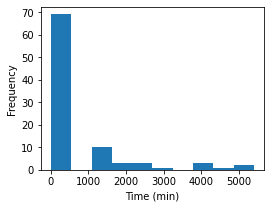

In [91]:
plt.figure(figsize=figsize)
plt.hist(df['Duration'])
plt.ylabel('Frequency')
plt.xlabel('Time (min)')
plt.show()

I wonder what distribution does this follow ? <br>
I create a random discrete random variable from binned data, and fit both a exponential and power law distribution.

In [92]:
dur = df['Duration'].to_numpy()

h = np.histogram(dur, bins=1000)
D_emp = rv_histogram(h)

a, loc, scale = powerlaw.fit(dur)
D_power = powerlaw(a=a, loc=loc, scale=scale)

loc, scale = expon.fit(dur)
D_exp = expon(loc=loc, scale=scale)

X = np.linspace(np.min(dur), np.max(dur), 1000)

Unfortunately, as can bee seen the cdf's do not match, but they could serve as a approximation if need be.

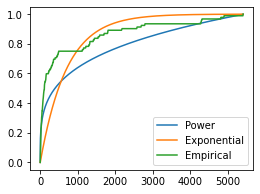

In [93]:
plt.figure(figsize=figsize)
plt.plot(X, D_power.cdf(X), label="Power")
plt.plot(X, D_exp.cdf(X), label="Exponential")
plt.plot(X, D_emp.cdf(X), label="Empirical")         
plt.legend(loc='best')
plt.show()

In [94]:
df_dur = df['Duration'].to_frame()
df_dur['Duration'] = df_dur['Duration'].apply(lambda x: timedelta(minutes=x))

#### Longest trades
The longest trade took almost 4 days.

In [95]:
df_dur = df_dur.sort_values('Duration', ascending=False)
df_dur.head(3)

,Duration
8,3 days 18:01:00
49,3 days 09:33:00
9,3 days 08:06:00


#### Shortest trades
The shortest trade took 2 minutes.

In [96]:
df_dur = df_dur.sort_values('Duration', ascending=True)
df_dur.head(3)

,Duration
31,00:02:00
30,00:02:00
65,00:03:00


#### Trade duration vs Profit Per Lot

The scatter plot shows that there seems to be a minimal relationship between the duration of a trade and its profitability. This is to be expected - as mentioned earlier the algorithm will hold on to winning trades.

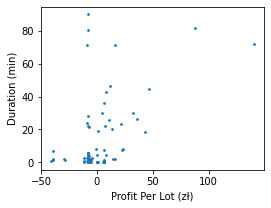

In [97]:
plt.figure(figsize=figsize)
plt.scatter(df['Profit Per Lot'], df['Duration'] / 60, s=3)
plt.ylabel("Duration (min)")
plt.xlabel("Profit Per Lot (zł)")
plt.show()

#### Average number of Trades Per Day

In [98]:
df_open = df[['Open Date', 'Profit']]
df_open = df_open.groupby(['Open Date'], as_index=False)
df_open = df_open.count()
df_open = df_open.rename(columns={'Profit': 'Trades Per Day'})

The average number of trades per day is:

In [99]:
np.round(df_open['Trades Per Day'].mean(), 2)

4.84

#### Trades Per Day histogram

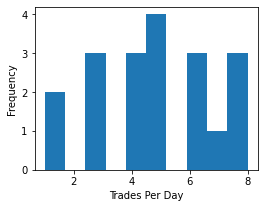

In [100]:
plt.figure(figsize=figsize)
plt.hist(df_open['Trades Per Day'])
plt.ylabel('Frequency')
plt.xlabel('Trades Per Day')
plt.show()

### Time spent in trade by market

I calculate the percent of time spent in trades by summing up all trade durations. I then divide that number by number of minutes in the trading period. As can be seen almost half the trading period the algorithms had positions in 'GBPUSD' and 'USDCHF'. The least time was spent trading 'OILWTI'.

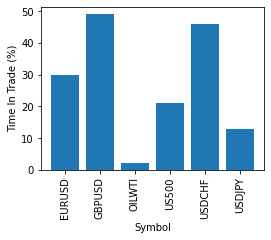

In [101]:
start = df['Open Date'].min()
stop = df['Close Date'].max()

total = (stop-start).total_seconds() / 60

df_time = df[['Symbol', 'Duration']].groupby('Symbol', as_index=False).sum() 
df_time['Percent'] = np.round(df_time['Duration'] / total * 100)

plt.figure(figsize=figsize)
plt.bar(df_time['Symbol'], df_time['Percent'])
plt.xticks(df_time['Symbol'], rotation=90)
plt.ylabel('Time In Trade (%)')
plt.xlabel('Symbol')
plt.show()

### Orders

There are 5 ways a order can get closed.
1. By me. (Did not occur)
2. By the algorithm.
3. Market moves above/below take profit.
4. Market moves above/below stop loss.
5. Broker closes trades open longer than one year. (Did not occur)

So I have 3 situations to examine.

#### Percent of stop loss  hits

In [102]:
np.round(df['Stop Loss Hit'].sum() / df.shape[0] * 100, 2)

84.78

#### Percent of take profit hits

In [103]:
np.round(df['Take Profit Hit'].sum() / df.shape[0] * 100, 2)

11.96

#### Percent closed by algorithms
Specifically, this is the percent of trades closed because the trade triggered different logic than moving take profit and stop loss orders.

In [104]:
np.round(np.sum((df['Take Profit Hit'] == 0) & (df['Stop Loss Hit'] == 0)) / df.shape[0] * 100, 2)

3.26

#### Stop order distance

This histogram is very interesting as it shows a way I could potentially improve the logic of my algorithm.
Placing orders 10% away from the market for the type of strategy the algorithms trade seems pointless.

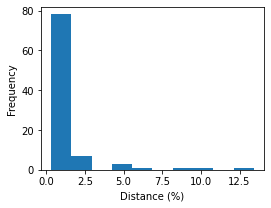

In [105]:
plt.figure(figsize=figsize)
plt.hist(df['Stops Distance'])
plt.ylabel('Frequency')
plt.xlabel('Distance (%)')
plt.show()

### Drawdown

In trading drawdown refers to the difference between the high point in a equity curve and succeding low point. I am interested in the the difference between the high point and the low point as well as the duration of the drawdown.

#### Max drawdown

I define a helper function to locate the points in question.

In [106]:
def max_drawdown(arr):
    
    size = arr.shape[0]
    arr = np.cumsum(arr)
    start = np.argmax(arr)
    stop = np.argmin(arr[start:])
    
    return start, arr[start], start + stop, arr[start + stop]

In [107]:
d1, v1, d2, v2 = max_drawdown(df['Profit'])

#### Cumulative profit

I draw a plot of the cumulative profit over time and mark the high and low points.

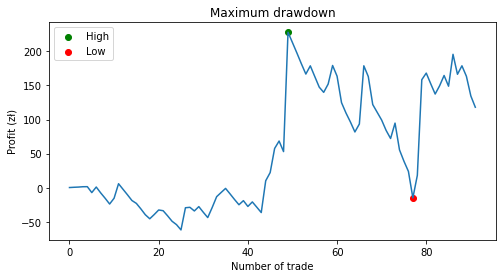

In [122]:
width = 800
height = 400
dpi = 100

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(np.cumsum(df['Profit']))
plt.ylabel("Profit (zł)")
plt.xlabel("Number of trade")
plt.scatter(d1, v1, c="green", label="High")
plt.scatter(d2, v2, c="red", label="Low")
plt.legend(loc='best')
plt.title('Maximum drawdown')
plt.savefig('./img/drawdown.png')
plt.show()

#### Max drawdown duration
I find that the duration of the max drawdown was:

In [109]:
drawdown_dur = df.loc[d2, "Open Datetime"] - df.loc[d1, "Open Datetime"]
str(drawdown_dur)

'4 days 03:48:00'

#### Time in max drawdown
Percent of time spent in drawdown:

In [110]:
np.round(drawdown_dur.total_seconds() / total / 60 * 100, 2) 

14.85

#### Max drawdown amount
The difference between the high point in the equity curve and the low point is:

In [111]:
v1 - v2

243.01

# Monte Carlo

### Simulating trades

<b>Assumption</b>:<br>
* Future trades will be similar to the ones in the dataset. <br>
* The algorithms trade size is fixed at 0.01 lots.

The 'Profit Per Lot' column is sampled with replacement and summed up to simulate possible outcomes for the next 100 trades.

I shall answer the following questions:
1. What is the probability that over the next 100 trades the account will grow ?
2. How much can I expect to lose in the worst case ?
3. How much can I expect to gain in the best case ?

Below is a visual to explain the process. Each line represents a different 'future'. I am interested in the distribution of these 'futures'.

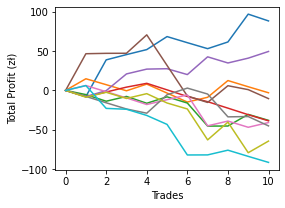

In [112]:
plt.figure(figsize=figsize)
np.random.seed(12346)

for _ in range(10):
    
    X = np.random.choice(df['Profit Per Lot'], replace=True, size=10)
    X = np.hstack([np.array([0]), X])
    plt.plot(np.cumsum(X))
    plt.xlabel("Trades")
    plt.ylabel("Total Profit (zł)")

100000 samples are chosen with replacement and summed up to get the final profit.

In [113]:
nrows = 10**5 # Number of simulations
ncols = 10**2 # Number of trades

X = np.random.choice(df['Profit Per Lot'], replace=True, size=(nrows, ncols))
X = np.cumsum(X, axis=1)
X = X[:, ncols-1]
density, bins = np.histogram(X, density=True, bins=200)
X_unity = density / density.sum()

### PDF from simulation

I use the data from the simulation to create a pdf.

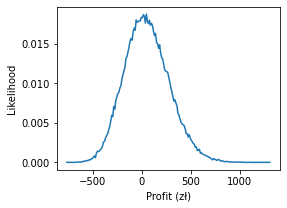

In [114]:
plt.figure(figsize=figsize)
plt.plot(bins[1:], X_unity)
plt.ylabel("Likelihood")
plt.xlabel("Profit (zł)")
plt.show()

### CDF from simulation

I use the data from the simulation to create a cdf.

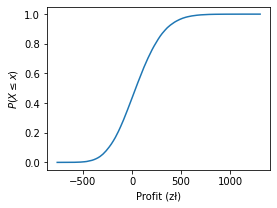

In [115]:
plt.figure(figsize=figsize)
plt.plot(bins[1:], np.cumsum(X_unity))
plt.ylabel(r"$P(X \leq x)$")
plt.xlabel("Profit (zł)")
plt.show()

### Probability of profit

From the simulated data I can calculate the probability of making money over the next 100 trades:

In [116]:
np.round(np.sum(X > 0) / X.shape[0] * 100, 2)

56.63

### Best case scenario

In the best case scenario I can expect to make:

In [117]:
alpha = 0.05
np.round(np.quantile(X, 1-alpha), 2)

443.62

The maximum profit in the simulation was:

In [118]:
np.round(np.max(X), 2)

1305.32

### Worst case scenario
In the worst case scenario I can expect to lose:

In [119]:
np.round(np.quantile(X, alpha), 2)

-306.93

The minimum profit in the simulation was:

In [120]:
np.round(np.min(X))

-773.0